In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm.notebook import tqdm_notebook
from joblib import Parallel, delayed
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke

from extract_linestrings import *

In [3]:
def compute_sidewalk_availability(city):
    
        osm_file = 'data/osm/'+city+'.osm.pbf'
        h = WayHandler()
        h.apply_file(osm_file, locations = True)

        w_sidewalk = h.get_gdf(highway_with_sidewalk)
        wo_sidewalk = h.get_gdf(highway_without_sidewalk)
        wo_sidewalk_tag = h.get_gdf(highway_without_sidewalk_tag)
        sidewalk = h.get_gdf(sidewalk_qualifer)
        footway = h.get_gdf(footway_qualifier)
        crossing = h.get_gdf(highway_crossing_qualifer)

        highway_count = len(w_sidewalk) + len(wo_sidewalk) + len(wo_sidewalk_tag)
        sidewalk_tag_percentage = ((len(w_sidewalk) + len(wo_sidewalk)) / highway_count) * 100
        sidewalk_count = len(sidewalk)
        footway_count = len(footway)
        crossing_count = len(crossing)
        highway_to_sidewalk_ratio = sidewalk_count / highway_count

        return  [
                    city,
                    highway_count,
                    len(w_sidewalk),
                    len(wo_sidewalk),
                    len(wo_sidewalk_tag),
                    sidewalk_tag_percentage,
                    sidewalk_count,
                    footway_count,
                    crossing_count,
                    highway_to_sidewalk_ratio
                ]

In [4]:
cities = pd.read_csv('data/picked_cities.csv')
cities = cities['abbr'].to_list()

In [5]:
stat_cities = Parallel(n_jobs=12)(
    delayed(compute_sidewalk_availability)(city) for city in cities
    ) # Almost 7x speed up than serial execution

In [7]:
colnames = ['city', 
            'highway_count', 
            'highway_with_sidewalk', 
            'highway_without_sidewalk',
            'highway_without_sidewalk_tag',
            'sidewalk_tag_percentage(%)', 
            'sidewalk_count', 
            'footway_count', 
            'crossing_count', 
            'highway_to_sidewalk_ratio']

df = pd.DataFrame(stat_cities, columns=colnames)
df = df.sort_values(by=['sidewalk_tag_percentage(%)'])

In [9]:
df.to_csv('data/all_cities_sidewalk_stats.csv', index = None)

In [73]:
stats = pd.read_csv('data/all_cities_sidewalk_stats.csv')
stats.head(10)

,city,highway_count,highway_with_sidewalk,highway_without_sidewalk,highway_without_sidewalk_tag,sidewalk_tag_percentage(%),sidewalk_count,footway_count,crossing_count,highway_to_sidewalk_ratio
0,bri,5646,3,0,5643,0.053135,155,1138,87,0.027453
1,veg,68217,38,5,68174,0.063034,956,4665,244,0.014014
2,tol,21924,12,2,21910,0.063857,3403,8415,1805,0.155218
3,laf,7484,3,5,7476,0.106895,60,498,31,0.008017
4,dmo,20327,15,11,20301,0.127909,5463,11671,2775,0.268756
5,tij,48061,51,17,47993,0.141487,841,3963,377,0.017499
6,far,12433,17,1,12415,0.144776,1443,4673,863,0.116062
7,new,15890,25,0,15865,0.157332,573,3201,590,0.036060
8,cnc,7363,3,11,7349,0.190140,875,2726,999,0.118837
9,sio,13480,25,1,13454,0.192878,380,1595,146,0.028190


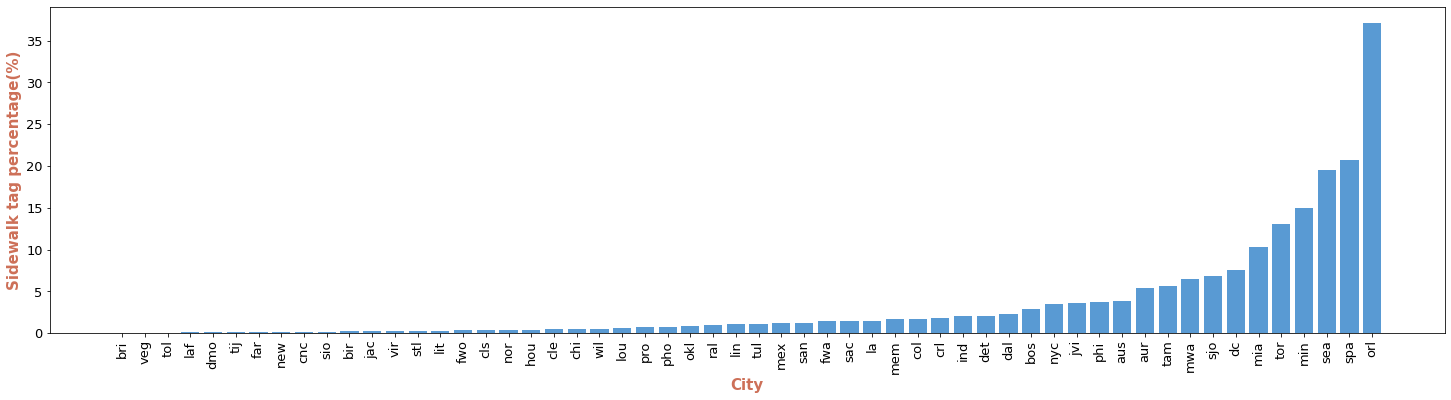

In [67]:
fig, ax = plt.subplots(figsize=(25, 6))

height = stats['sidewalk_tag_percentage(%)']
bars = stats['city']

x_pos = np.arange(len(bars))
ax.bar(x_pos, height, color='#599ad3')

# Rotation of the bar names
plt.xticks(x_pos, bars, rotation=90, fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Sidewalk tag percentage(%)', fontweight='bold', color = '#cd7058', fontsize='15')
plt.xlabel('City', fontweight='bold', color = '#cd7058', fontsize='15')

# Show graphic
plt.show()

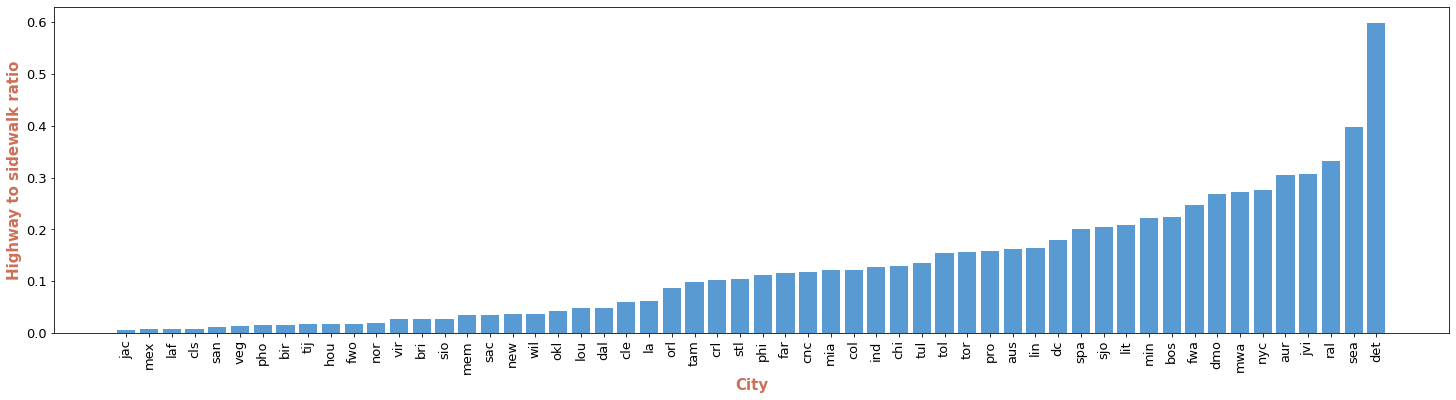

In [77]:
fig, ax = plt.subplots(figsize=(25, 6))

temp = stats.sort_values(by=['highway_to_sidewalk_ratio'])

height = temp['highway_to_sidewalk_ratio']
bars = temp['city']

x_pos = np.arange(len(bars))
ax.bar(x_pos, height, color='#599ad3')

# Rotation of the bar names
plt.xticks(x_pos, bars, rotation=90, fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Highway to sidewalk ratio', fontweight='bold', color = '#cd7058', fontsize='15')
plt.xlabel('City', fontweight='bold', color = '#cd7058', fontsize='15')

# Show graphic
plt.show()